In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import warnings
import sys
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import string
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMModel, LGBMClassifier, plot_importance
from sklearn.ensemble import GradientBoostingClassifier
import sklearn, xgboost, lightgbm
import joblib

In [2]:
df = pd.read_csv('data/drugsComTrain_raw.csv')
test = pd.read_csv('data/drugsComTest_raw.csv')
df.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

In [3]:
#combining datasets as they both have same columns
data = pd.concat([df, test])
data.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

In [4]:
print("Combined dataset shape:", data.shape)

Combined dataset shape: (215063, 7)


In [5]:
# describing the data
data.describe()

uniqueID         rating    usefulCount
count  215063.000000  215063.000000  215063.000000
mean   116039.364814       6.990008      28.001004
std     67007.913366       3.275554      36.346069
min         0.000000       1.000000       0.000000
25%     58115.500000       5.000000       6.000000
50%    115867.000000       8.000000      16.000000
75%    173963.500000      10.000000      36.000000
max    232291.000000      10.000000    1291.000000

In [6]:
# information from the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 13.1+ MB


In [7]:
# datatype of columns
data.dtypes

uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

In [8]:
# checking for null values
data.isnull().any()

uniqueID       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

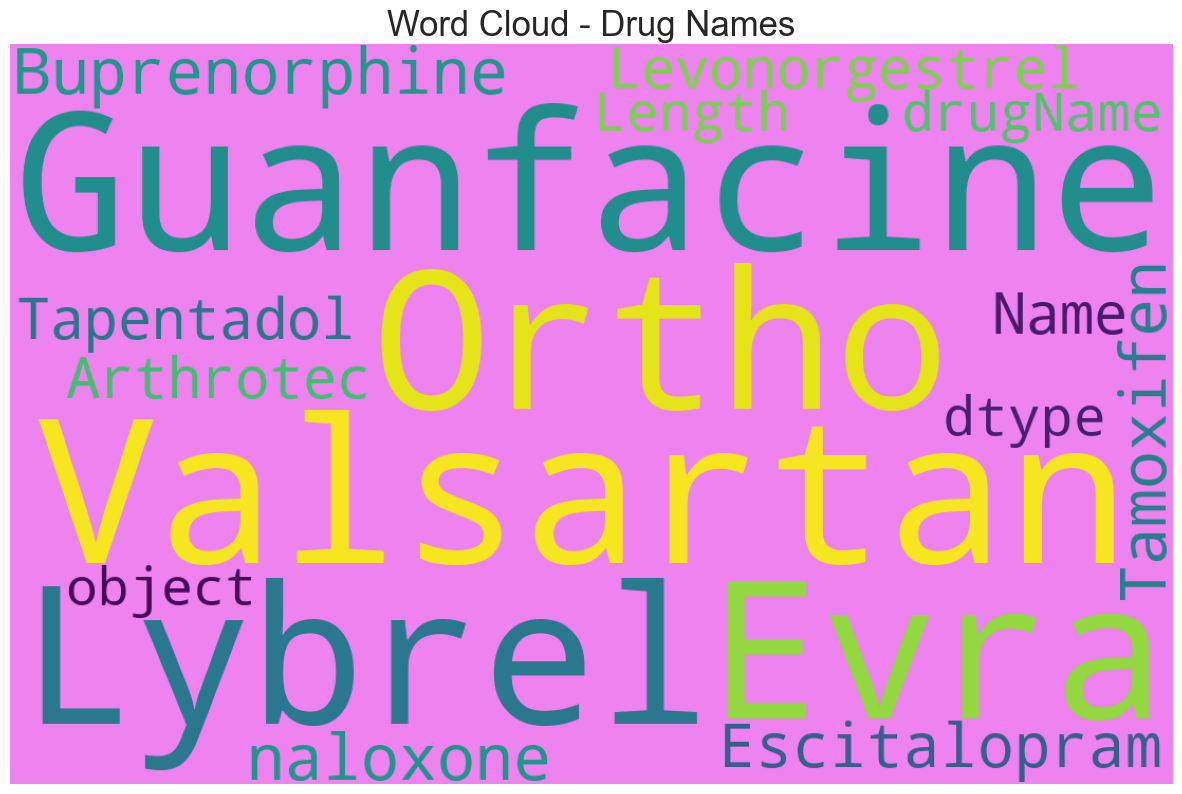

In [11]:
# let's see the words cloud for the drug names 

# most popular drugs

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color = 'violet', stopwords = stopwords, width = 1100, height = 700).generate(str(data['drugName']))

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud - Drug Names', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

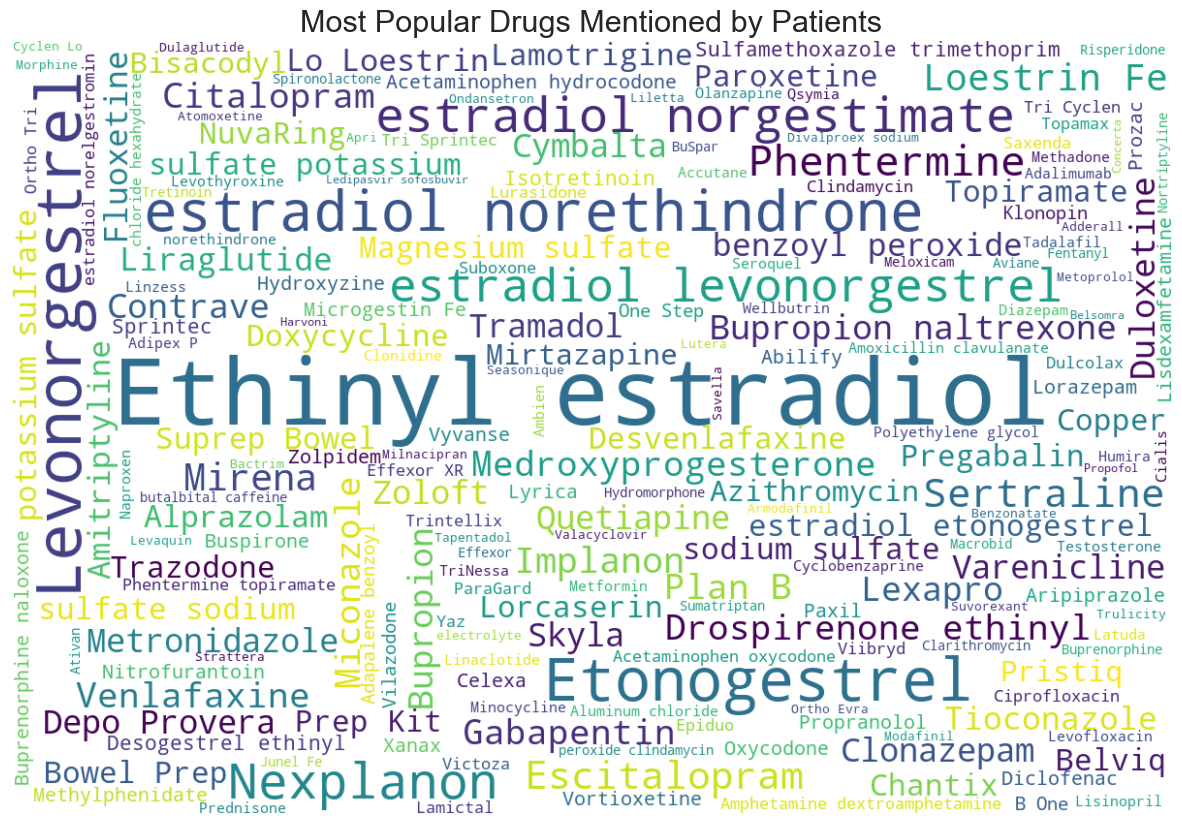

In [12]:
# Word Cloud for Most Frequent Drug Names

from wordcloud import WordCloud, STOPWORDS

# Define stopwords
stopwords = set(STOPWORDS)

all_drugs_text = ' '.join(data['drugName'].astype(str))

# Create WordCloud
wordcloud = WordCloud(
    background_color='white',     
    stopwords=stopwords,
    colormap='viridis',           
    width=1200,
    height=800,
    contour_color='steelblue',  
    contour_width=2
).generate(all_drugs_text)

# Plot settings
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Popular Drugs Mentioned by Patients', fontsize=22)

plt.savefig("drugname_wordcloud.png", bbox_inches='tight')

plt.show()

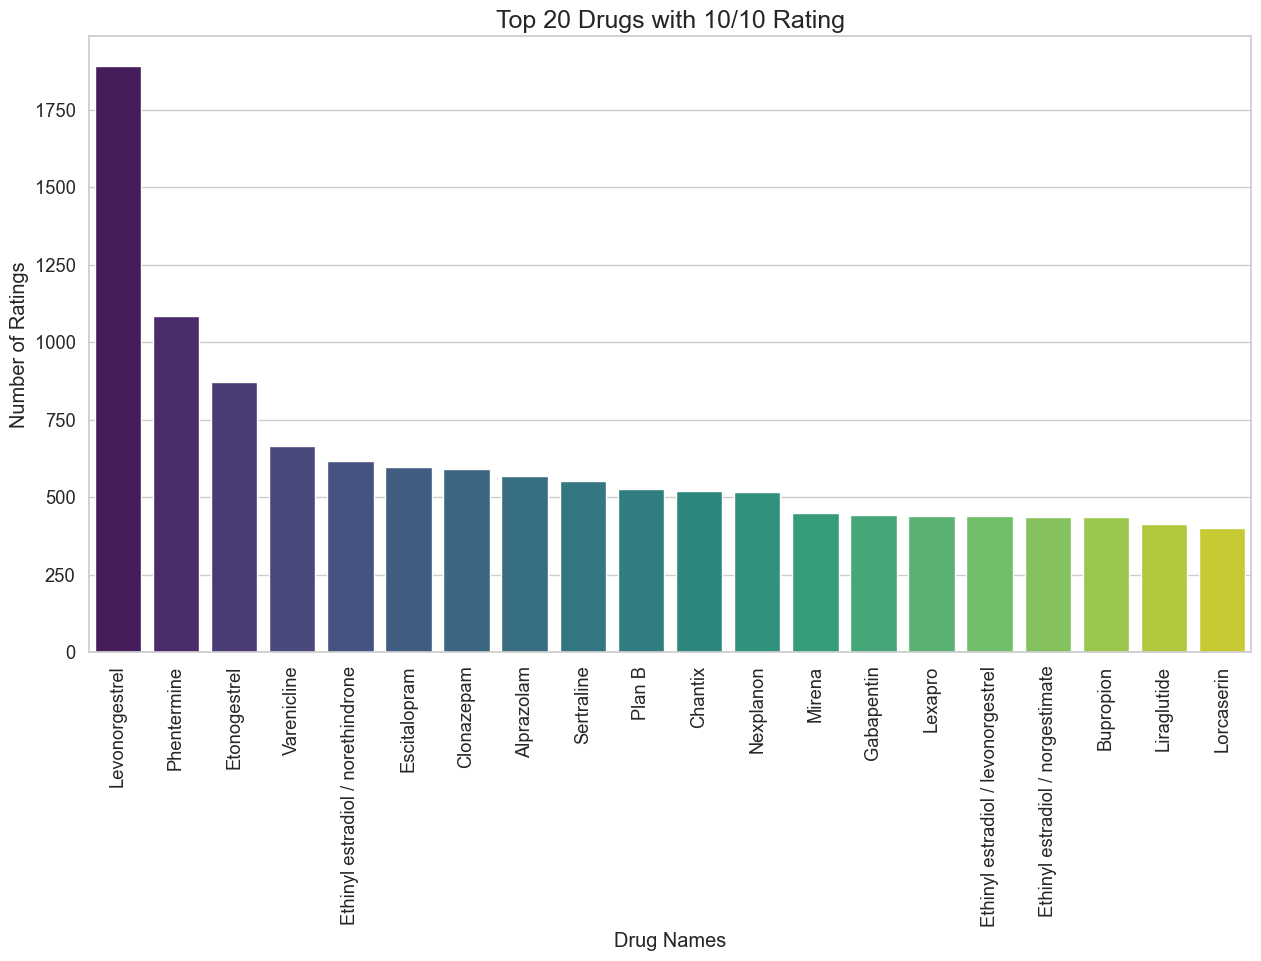

In [13]:
# Top 20 drugs with perfect rating (10/10)
sns.set(font_scale=1.2, style='whitegrid')
plt.rcParams['figure.figsize'] = [15, 8]

# Count drugs with rating 10
drug_counts = dict(data.loc[data.rating == 10, "drugName"].value_counts())
drug_labels = list(drug_counts.keys())
counts = list(drug_counts.values())

sns_rating = sns.barplot(
    x=drug_labels[0:20],
    y=counts[0:20],
    palette='viridis'
)

sns_rating.set_title('Top 20 Drugs with 10/10 Rating', fontsize=18)
sns_rating.set_xlabel("Drug Names")
sns_rating.set_ylabel("Number of Ratings")
plt.setp(sns_rating.get_xticklabels(), rotation=90)
plt.show()

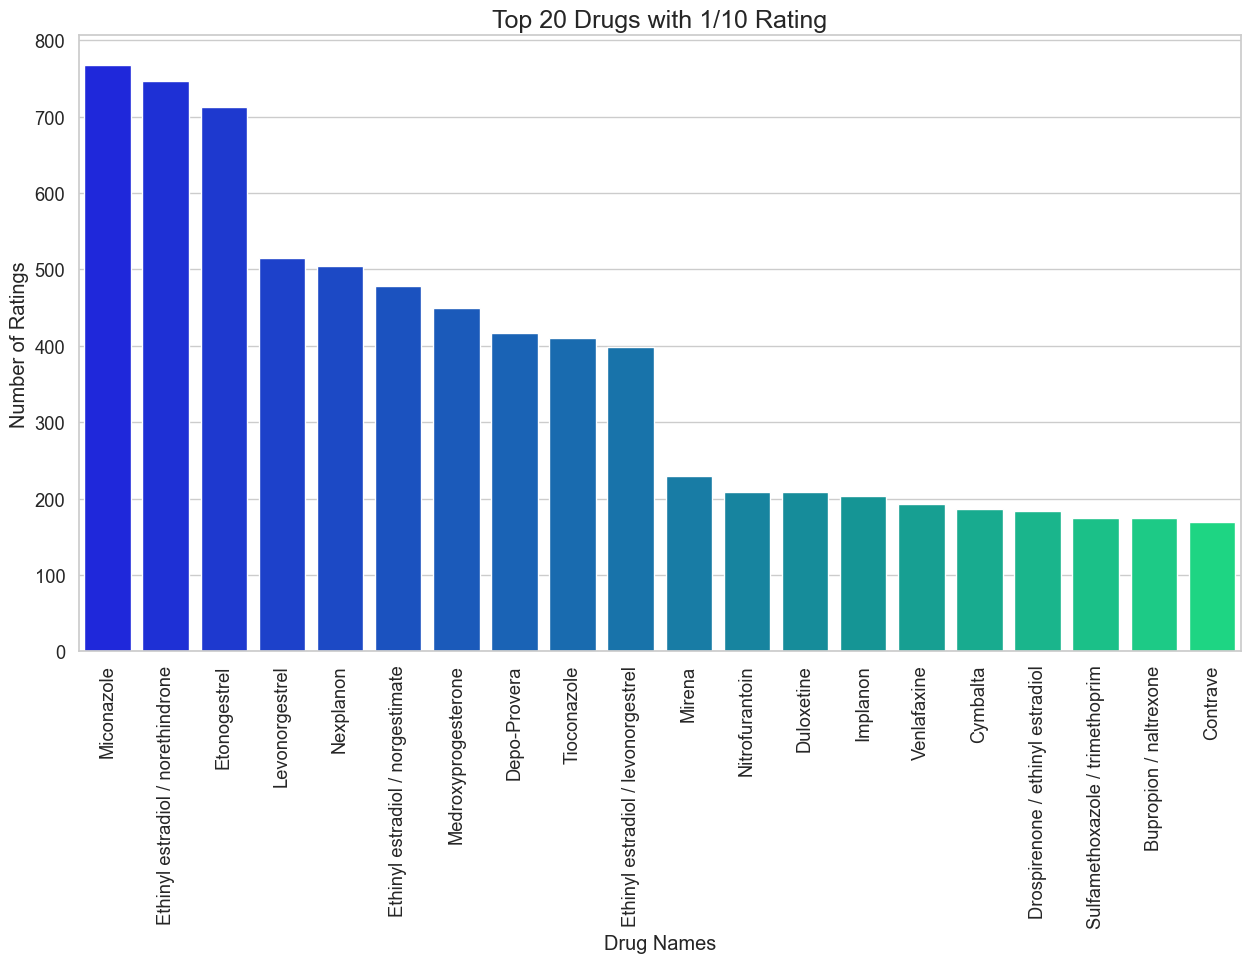

In [14]:
# Top 20 drugs with lowest rating (1/10)
sns.set(font_scale=1.2, style='whitegrid')
plt.rcParams['figure.figsize'] = [15, 8]

# Count drugs with rating 1
low_rating_counts = dict(data.loc[data.rating == 1, "drugName"].value_counts())
drug_labels = list(low_rating_counts.keys())
counts = list(low_rating_counts.values())

sns_rating = sns.barplot(
    x=drug_labels[0:20],
    y=counts[0:20],
    palette='winter'
)

sns_rating.set_title('Top 20 Drugs with 1/10 Rating', fontsize=18)
sns_rating.set_xlabel("Drug Names")
sns_rating.set_ylabel("Number of Ratings")
plt.setp(sns_rating.get_xticklabels(), rotation=90)
plt.show()


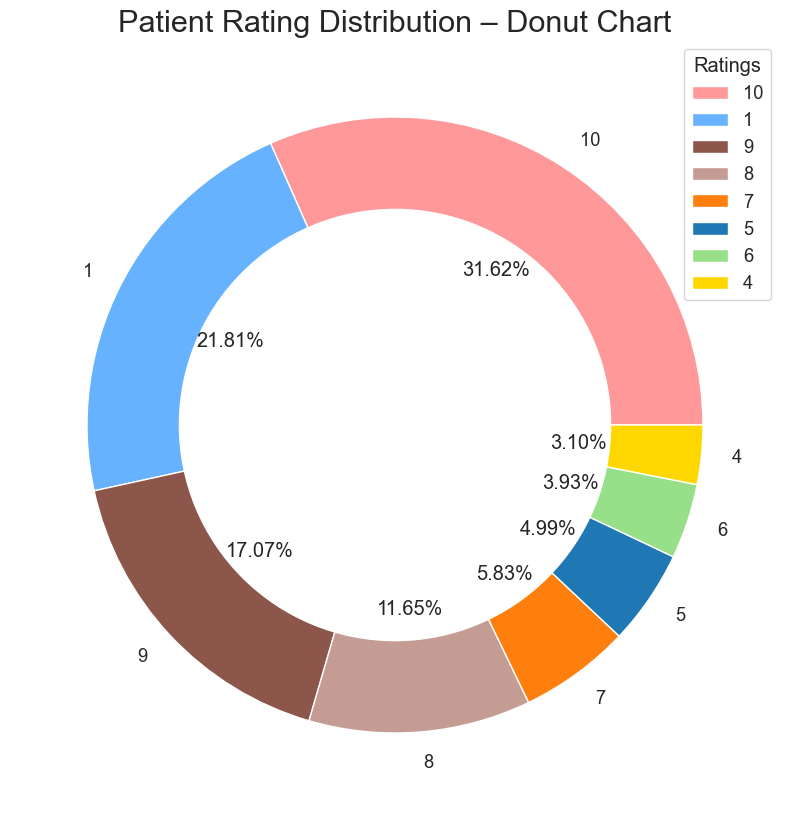

In [15]:
# Donut Chart: Share of Each Rating
rating_counts = [68005, 46901, 36708, 25046, 12547, 10723, 8462, 6671]
donut_colors = ['#FF9999','#66B2FF','#8C564B','#C49C94','#FF7F0E','#1F77B4','#98DF8A','#FFD700']
rating_labels = ["10", "1", "9", "8", "7", "5", "6", "4"]

my_circle = plt.Circle((0,0),0.7, color='white')

plt.figure(figsize=(10,10))
plt.pie(rating_counts, labels=rating_labels, colors=donut_colors, autopct='%.2f%%')
plt.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Patient Rating Distribution – Donut Chart', fontsize=22)
plt.legend(title="Ratings", loc="upper right")
plt.show()

THE PIECHART REPRESENTS THE RATING OF REVIEWS

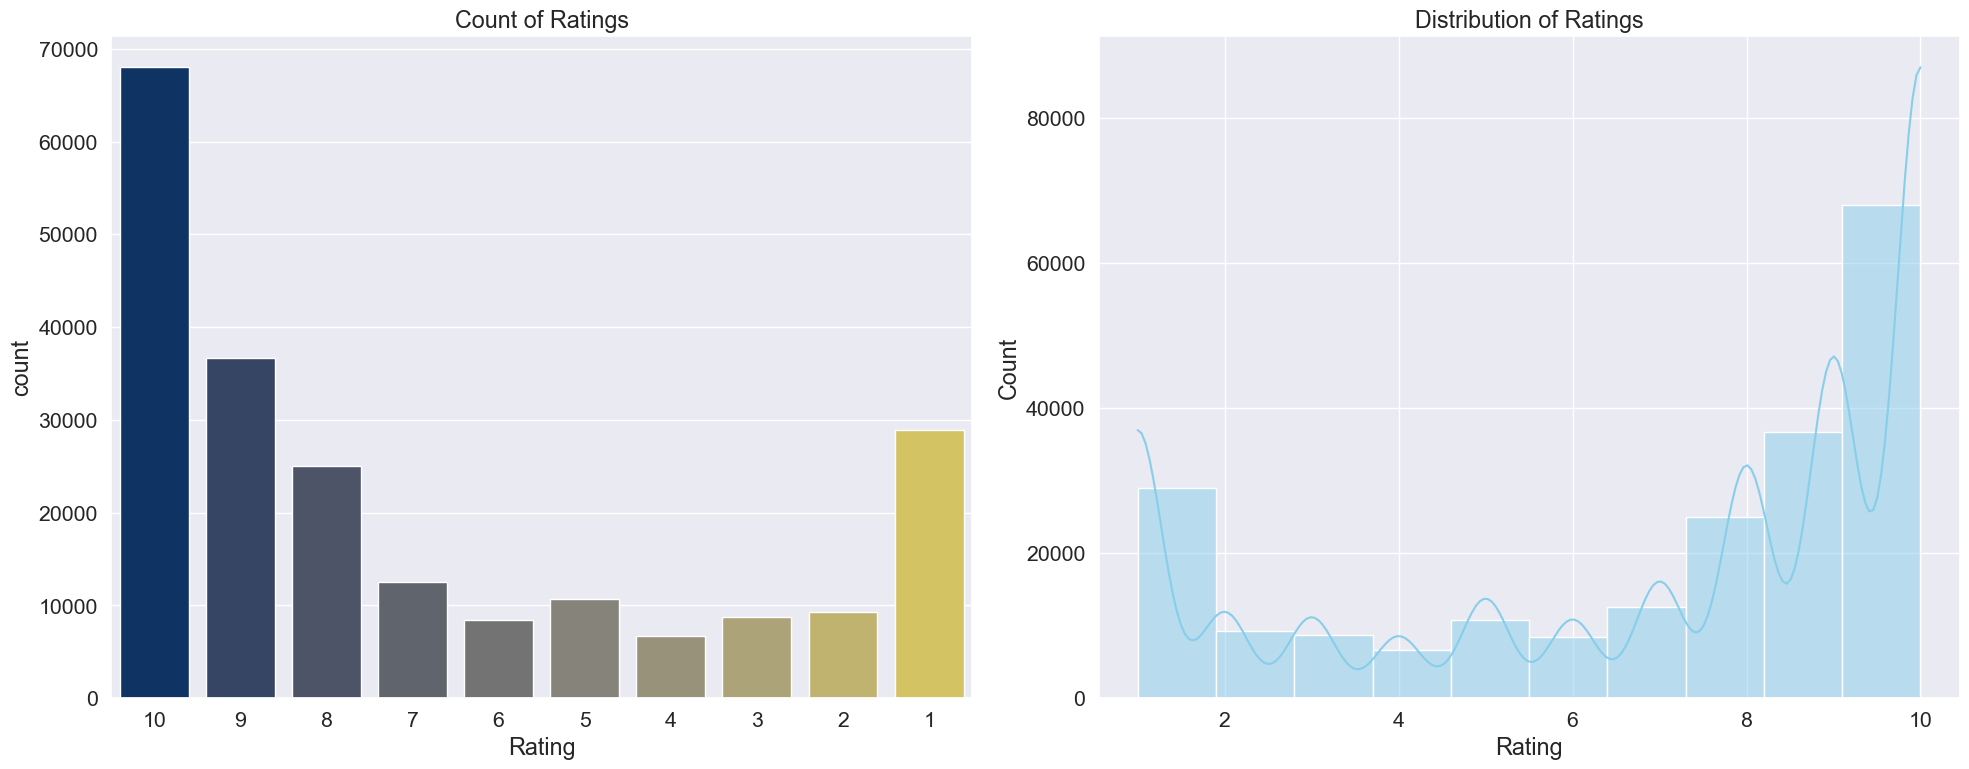

In [16]:
#  Countplot & Histogram to visualize ratings distribution
plt.rcParams['figure.figsize'] = [20, 8]
sns.set(font_scale=1.4, style='darkgrid')

fig, ax = plt.subplots(1, 2)

# Countplot
count_plot = sns.countplot(x=data['rating'], palette='cividis', order=list(range(10,0,-1)), ax=ax[0])
count_plot.set_title('Count of Ratings')
count_plot.set_xlabel("Rating")

# Histogram
dist_plot = sns.histplot(data['rating'], bins=10, kde=True, color='skyblue', ax=ax[1])
dist_plot.set_title('Distribution of Ratings')
dist_plot.set_xlabel("Rating")

plt.tight_layout()
plt.show()

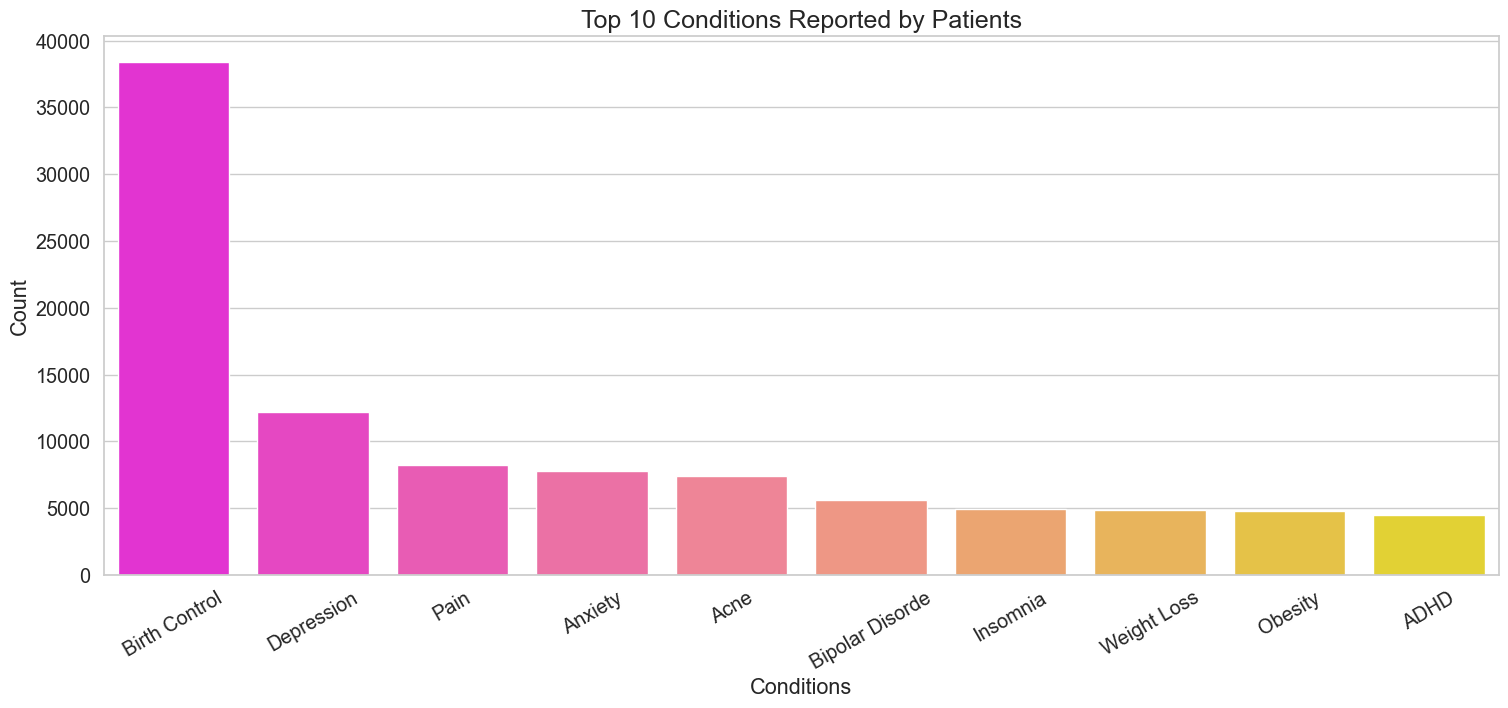

In [17]:
cond = dict(data['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]

sns.set(style='whitegrid', font_scale=1.3)
plt.rcParams['figure.figsize'] = [18, 7]

sns_ = sns.barplot(x=top_condition, y=values, palette='spring')
sns_.set_title("Top 10 Conditions Reported by Patients", fontsize=18)
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count")
plt.xticks(rotation=30)
plt.show()


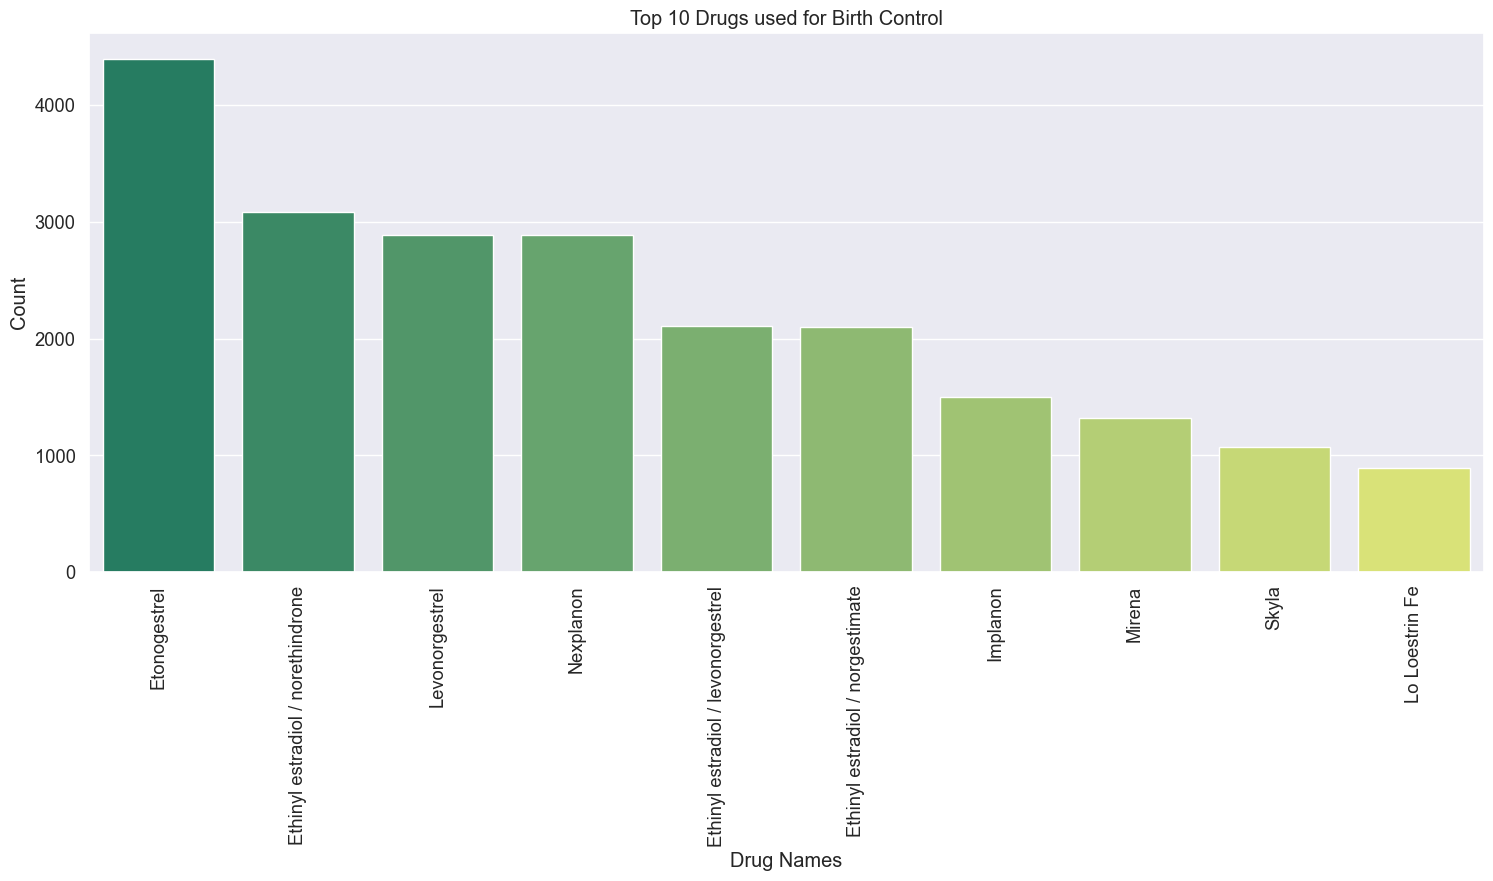

In [18]:
# Top 10 drugs which are used for Birth Control
df1 = data[data['condition'] == 'Birth Control']['drugName'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df1.index, y = df1.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_ylabel('Count')  
sns_.set_title("Top 10 Drugs used for Birth Control")
plt.setp(sns_.get_xticklabels(), rotation = 90)
plt.show()

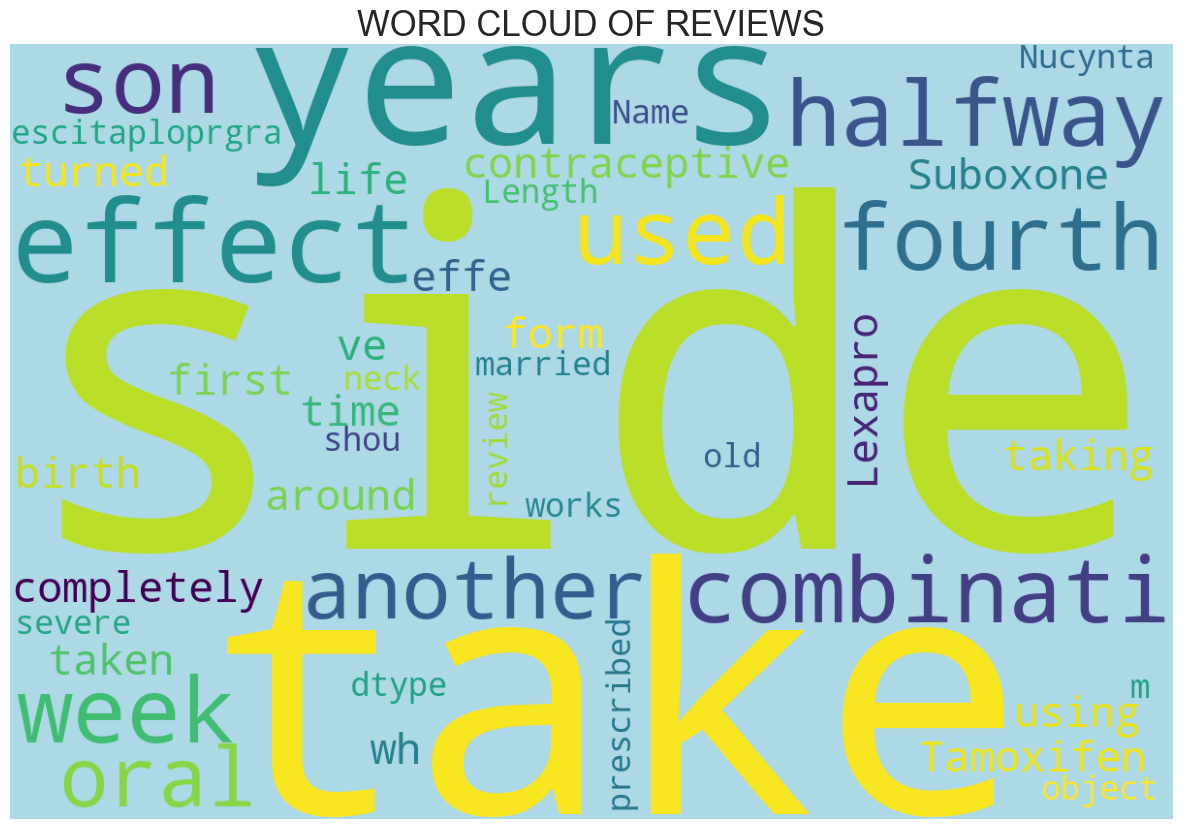

In [19]:
# word cloud for the reviews 
# most popular drugs

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color = 'lightblue', stopwords = stopwords, width = 1200, height = 800).generate(str(data['review']))

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('WORD CLOUD OF REVIEWS', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

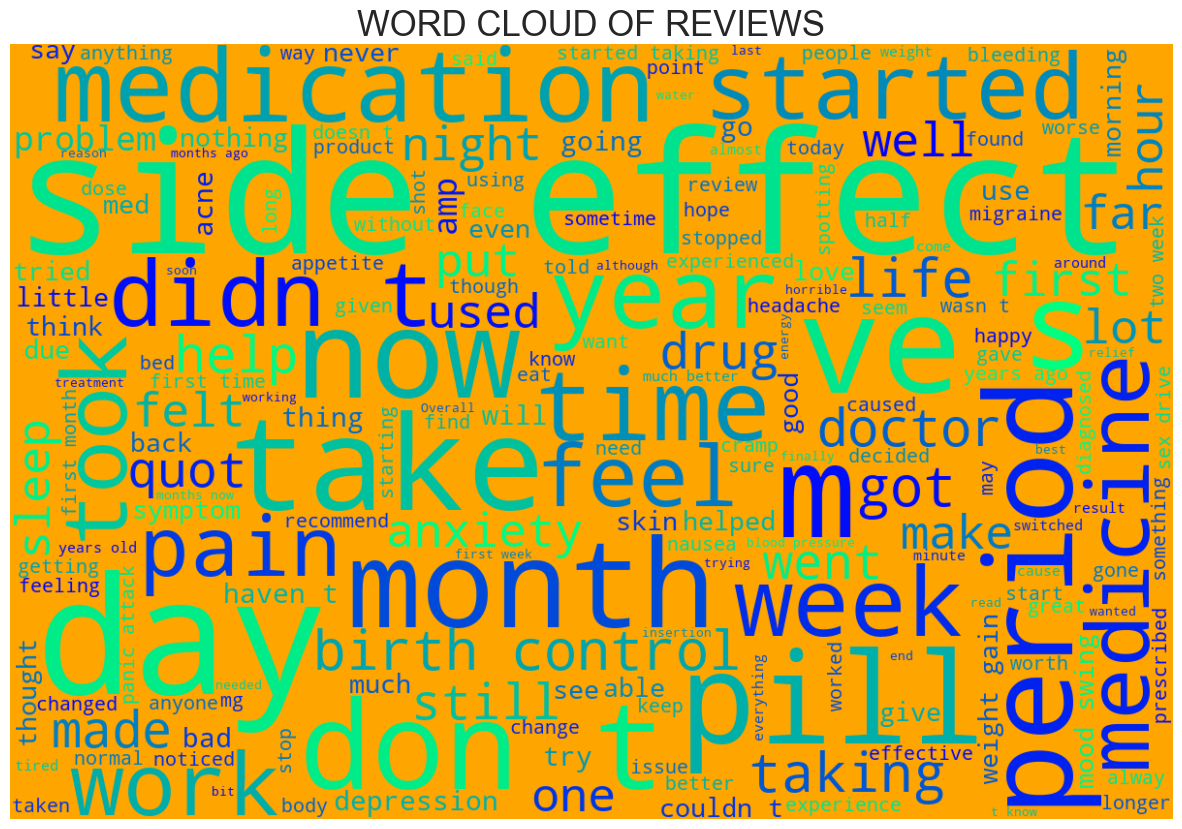

In [20]:
# Word Cloud of Patient Reviews:Shows most common words in reviews
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

all_reviews_text = ' '.join(data['review'].astype(str))

wordcloud = WordCloud(
    background_color='orange',  
    stopwords=stopwords,
    width=1200,
    height=800,
    colormap='winter',            
    contour_color='steelblue',
    contour_width=2
).generate(all_reviews_text)

plt.rcParams['figure.figsize'] = (15, 15)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WORD CLOUD OF REVIEWS', fontsize=25)
plt.show()

In [21]:
# Feature Engineering: binary sentiment based on ratings
# Ratings 5 and above are considered positive (1), below 5 negative (0)
data.loc[data['rating'] >= 5, 'Review_Sentiment'] = 1
data.loc[data['rating'] < 5, 'Review_Sentiment'] = 0

# distribution of Review_Sentiment
data['Review_Sentiment'].value_counts()

Review_Sentiment
1.0    161491
0.0     53572
Name: count, dtype: int64

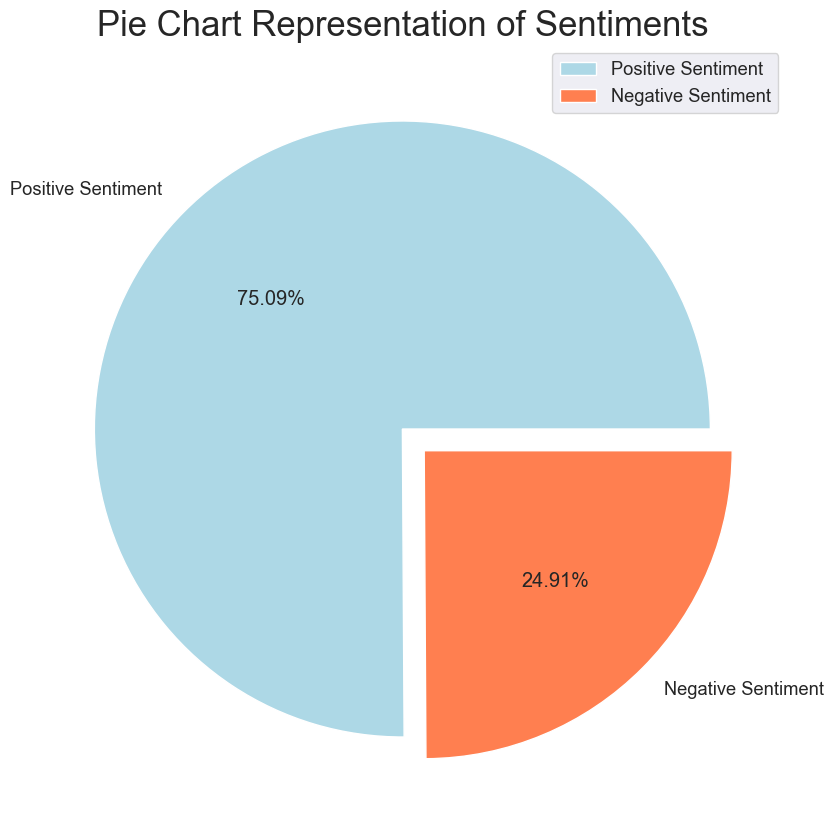

In [22]:
# Pie Chart to represent patient review sentiments
size = [161491, 53572]
colors = ['lightblue', 'coral']  
labels = "Positive Sentiment", "Negative Sentiment"
explode = [0, 0.1] 

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors=colors, labels=labels, explode=explode, autopct='%.2f%%')
plt.axis('off')
plt.title('Pie Chart Representation of Sentiments', fontsize=25)
plt.legend()
plt.show()

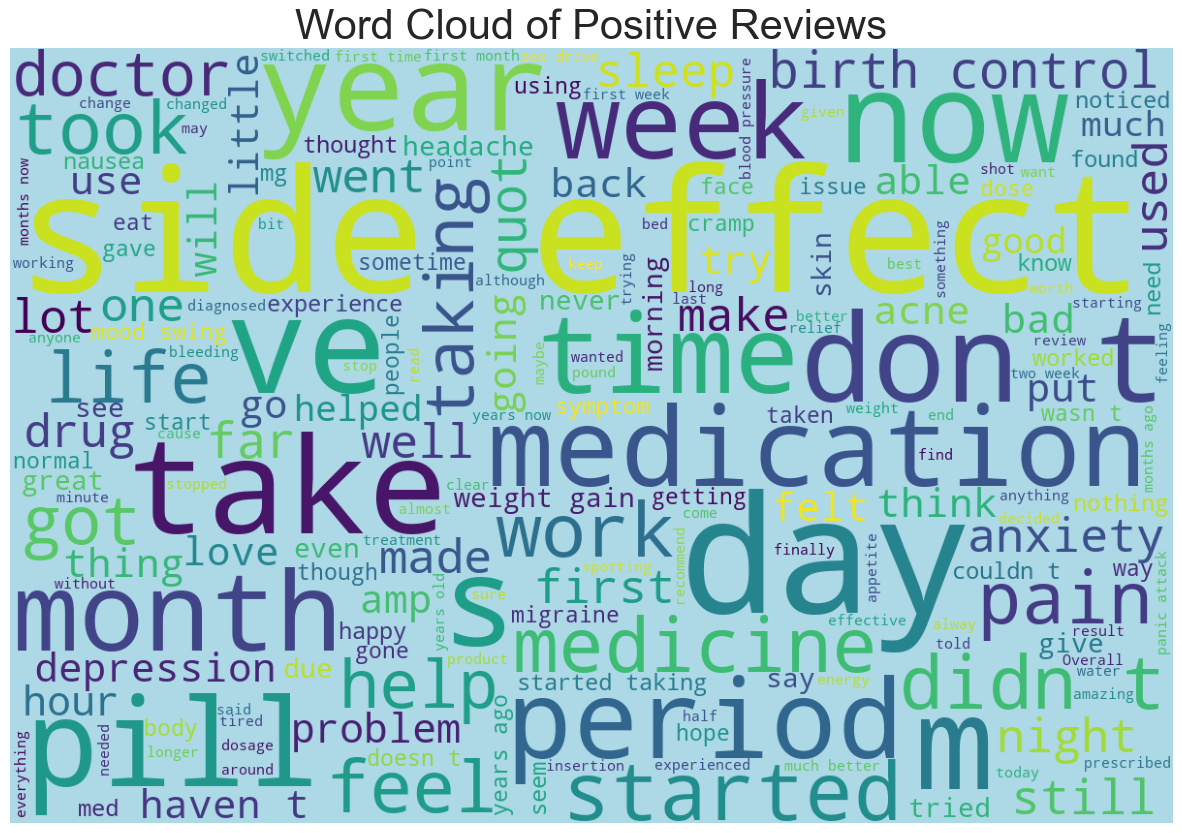

In [23]:
# Word cloud for the postive sentiments

positive_sentiments = " ".join([text for text in data['review'][data['Review_Sentiment'] == 1]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightblue', stopwords = stopwords, width = 1200, height = 800).generate(positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Positive Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

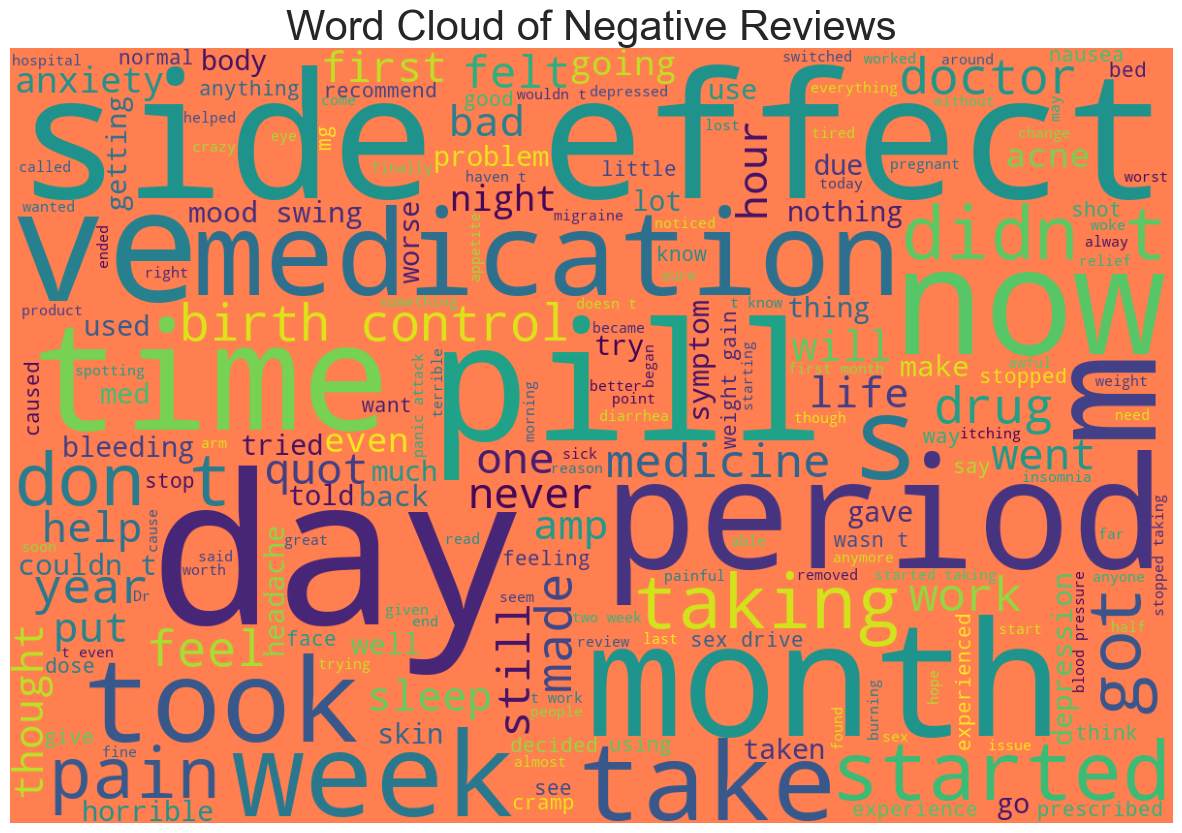

In [24]:
# Word cloud for the Negative sentiments

negative_sentiments = " ".join([text for text in data['review'][data['Review_Sentiment'] == 0]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'coral', stopwords = stopwords, width = 1200, height = 800).generate(negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Word Cloud of Negative Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [25]:
# converting the date into datetime format
data['date'] = pd.to_datetime(data['date'], errors = 'coerce')

# now extracting year from date
data['Year'] = data['date'].dt.year

# extracting the month from date
data['month'] = data['date'].dt.month

# extracting the days from the date
data['day'] = data['date'].dt.day

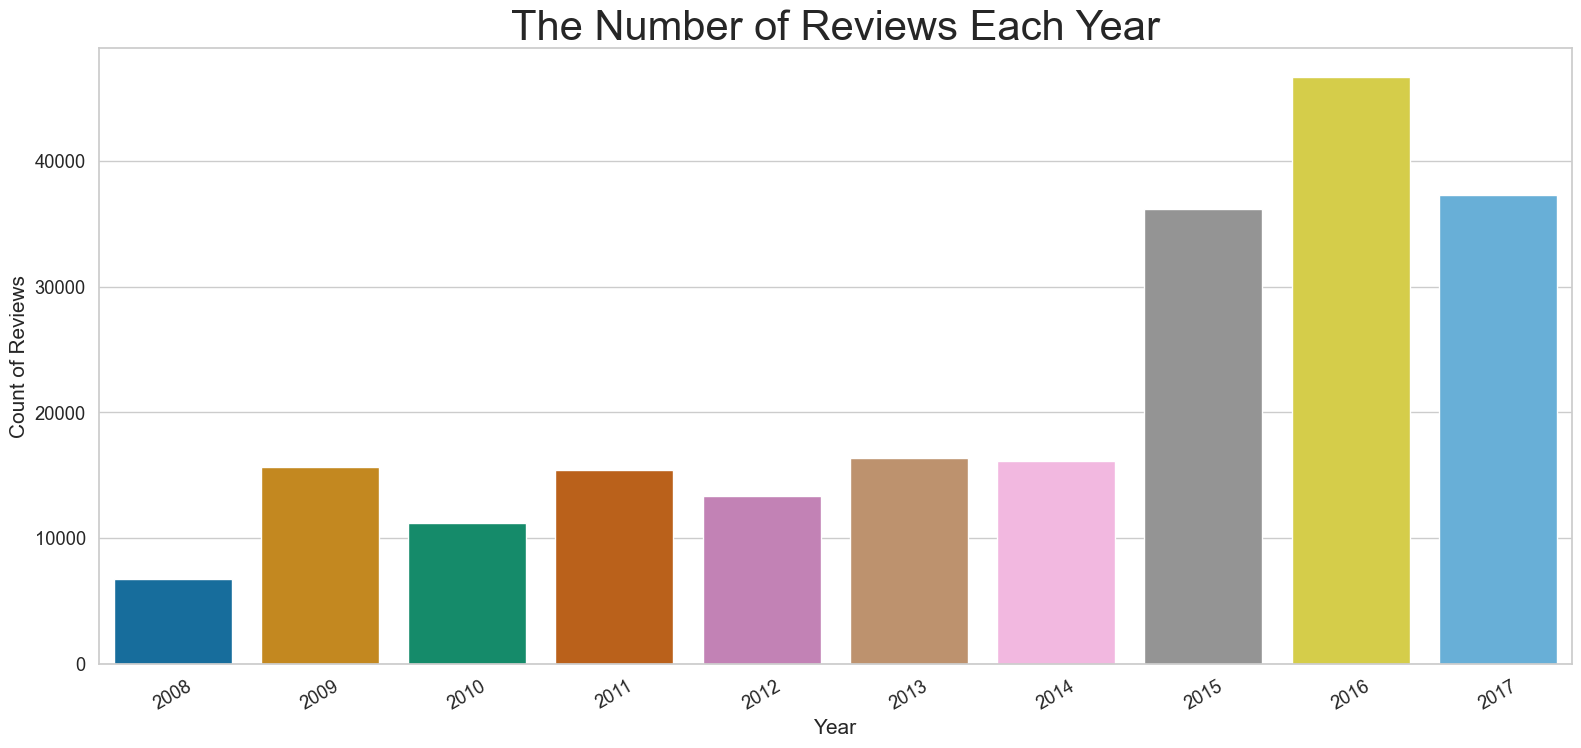

In [26]:
plt.figure(figsize=(19, 8))
sns.set(style='whitegrid', font_scale=1.2)

sns.countplot(x='Year', data=data, palette='colorblind')

plt.title('The Number of Reviews Each Year', fontsize=30)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Count of Reviews', fontsize=15)
plt.xticks(rotation=30)
plt.show()

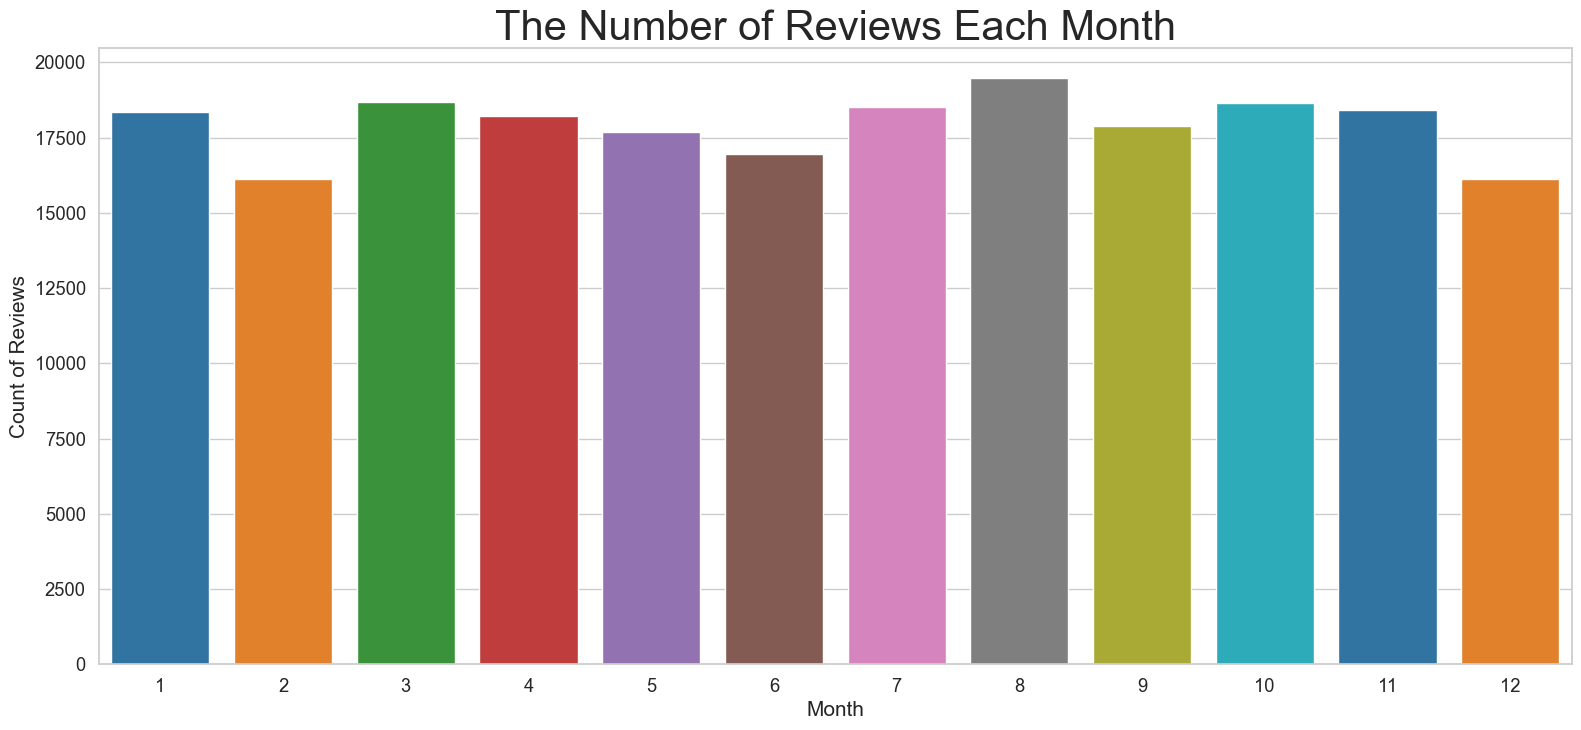

In [27]:
plt.figure(figsize=(19, 8))
sns.set(style='whitegrid', font_scale=1.2)

sns.countplot(x='month', data=data, palette='tab10')

plt.title('The Number of Reviews Each Month', fontsize=30)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Count of Reviews', fontsize=15)
plt.show()

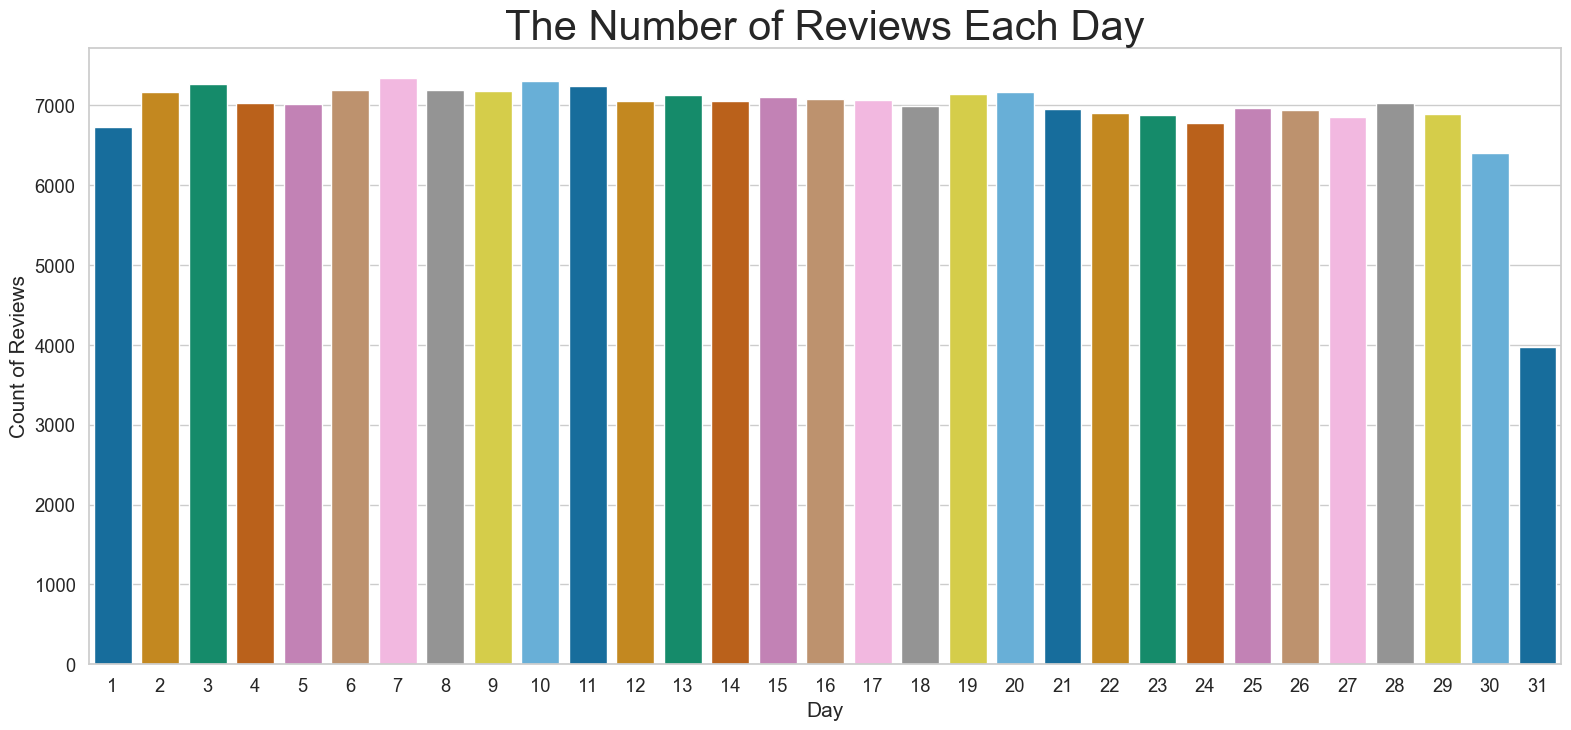

In [28]:
# looking at the no. of reviews in each day

plt.figure(figsize=(19, 8))
sns.set(style='whitegrid', font_scale=1.2)

sns.countplot(x='day', data=data, palette='colorblind')

plt.title('The Number of Reviews Each Day', fontsize=30)
plt.xlabel('Day', fontsize=15)
plt.ylabel('Count of Reviews', fontsize=15)
plt.show()

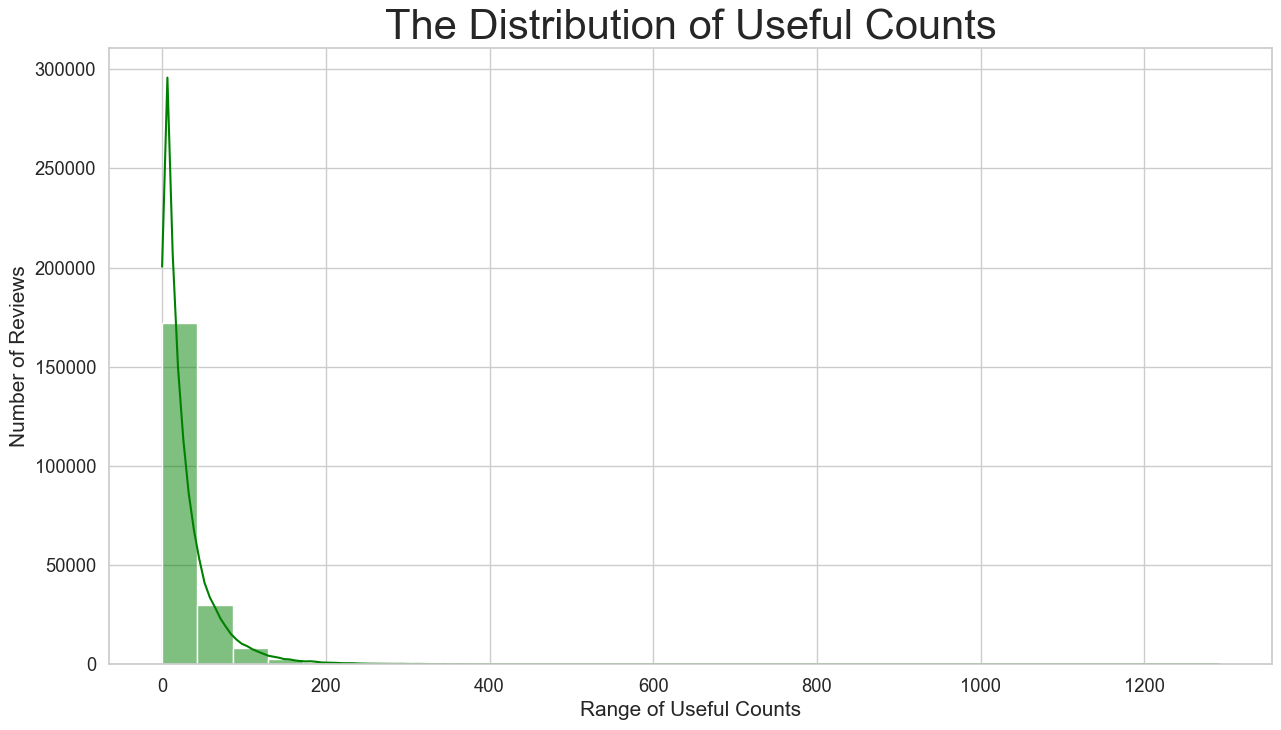

In [29]:
# Distribution of Useful Counts

plt.figure(figsize=(15, 8))
sns.set(style='whitegrid', font_scale=1.2)

sns.histplot(data['usefulCount'], kde=True, color='green', bins=30)

plt.title('The Distribution of Useful Counts', fontsize=30)
plt.xlabel('Range of Useful Counts', fontsize=15)
plt.ylabel('Number of Reviews', fontsize=15)
plt.show()

In [30]:
#Function to preprocess reviews for NLP analysis
def review_clean(review): 
    # changing to lower case
    lower = review.str.lower()
    
    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039;", "")
    
    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    
    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')
    
    return dataframe

In [31]:
data['review_clean'] = review_clean(data['review'])
from textblob import TextBlob
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

# Removing the stopwords
stop_words = set(stopwords.words('english'))
data['review_clean'] = data['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [32]:
data['review_clean'] = data['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
Snow_ball = SnowballStemmer("english")
data['review_clean'] = data['review_clean'].apply(lambda x: " ".join(Snow_ball.stem(word) for word in x.split()))
data['review_clean_no_stem'] = review_clean(data['review'])

In [33]:
def sentiment(review):
    # Sentiment polarity of the reviews
    polarity_scores = []
    for text in review:
        analysis = TextBlob(text)
        polarity_scores.append(analysis.sentiment.polarity)
    return polarity_scores

In [34]:
data['sentiment'] = sentiment(data['review'])
data['sentiment_clean'] = sentiment(data['review_clean'])
data['sentiment_clean_no_stem'] = sentiment(data['review_clean_no_stem'])
data = data.dropna(how="any", axis=0)

In [35]:
#Word count in each review
data['count_word']=data["review_clean"].apply(lambda x: len(str(x).split()))

#Unique word count 
data['count_unique_word']=data["review_clean"].apply(lambda x: len(set(str(x).split())))

#Letter count
data['count_letters']=data["review_clean"].apply(lambda x: len(str(x)))

#punctuation count
data["count_punctuations"] = data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
data["count_words_upper"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
data["count_words_title"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
data["count_stopwords"] = data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

#Average length of the words
data["mean_word_len"] = data["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [36]:
# Label Encoding, Frequency Encoding and Mean Sentiment Encoding for DrugName and Condition
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders
label_encoder_feat = {}

for feature in ['drugName', 'condition']:
    # Label Encoding
    label_encoder_feat[feature] = LabelEncoder()
    data[feature + '_LE'] = label_encoder_feat[feature].fit_transform(data[feature])
    
    # Frequency Encoding
    data[feature + '_freq'] = data[feature].map(data[feature].value_counts())
    
    # Mean sentiment encoding
    data[feature + '_mean_sentiment'] = data.groupby(feature)['Review_Sentiment'].transform('mean')

# The dataset now contains additional features: drugName_LE, condition_LE, drugName_freq, condition_freq, drugName_mean_sentiment, condition_mean_sentiment


In [37]:
import joblib

In [38]:
# Save freq and mean sentiment mappings
drug_freq_map = data.set_index('drugName')['drugName_freq'].to_dict()
drug_mean_sentiment_map = data.set_index('drugName')['drugName_mean_sentiment'].to_dict()

cond_freq_map = data.set_index('condition')['condition_freq'].to_dict()
cond_mean_sentiment_map = data.set_index('condition')['condition_mean_sentiment'].to_dict()

joblib.dump(drug_freq_map, "drug_freq_map.pkl")
joblib.dump(drug_mean_sentiment_map, "drug_mean_sentiment_map.pkl")
joblib.dump(cond_freq_map, "cond_freq_map.pkl")
joblib.dump(cond_mean_sentiment_map, "cond_mean_sentiment_map.pkl")

['cond_mean_sentiment_map.pkl']

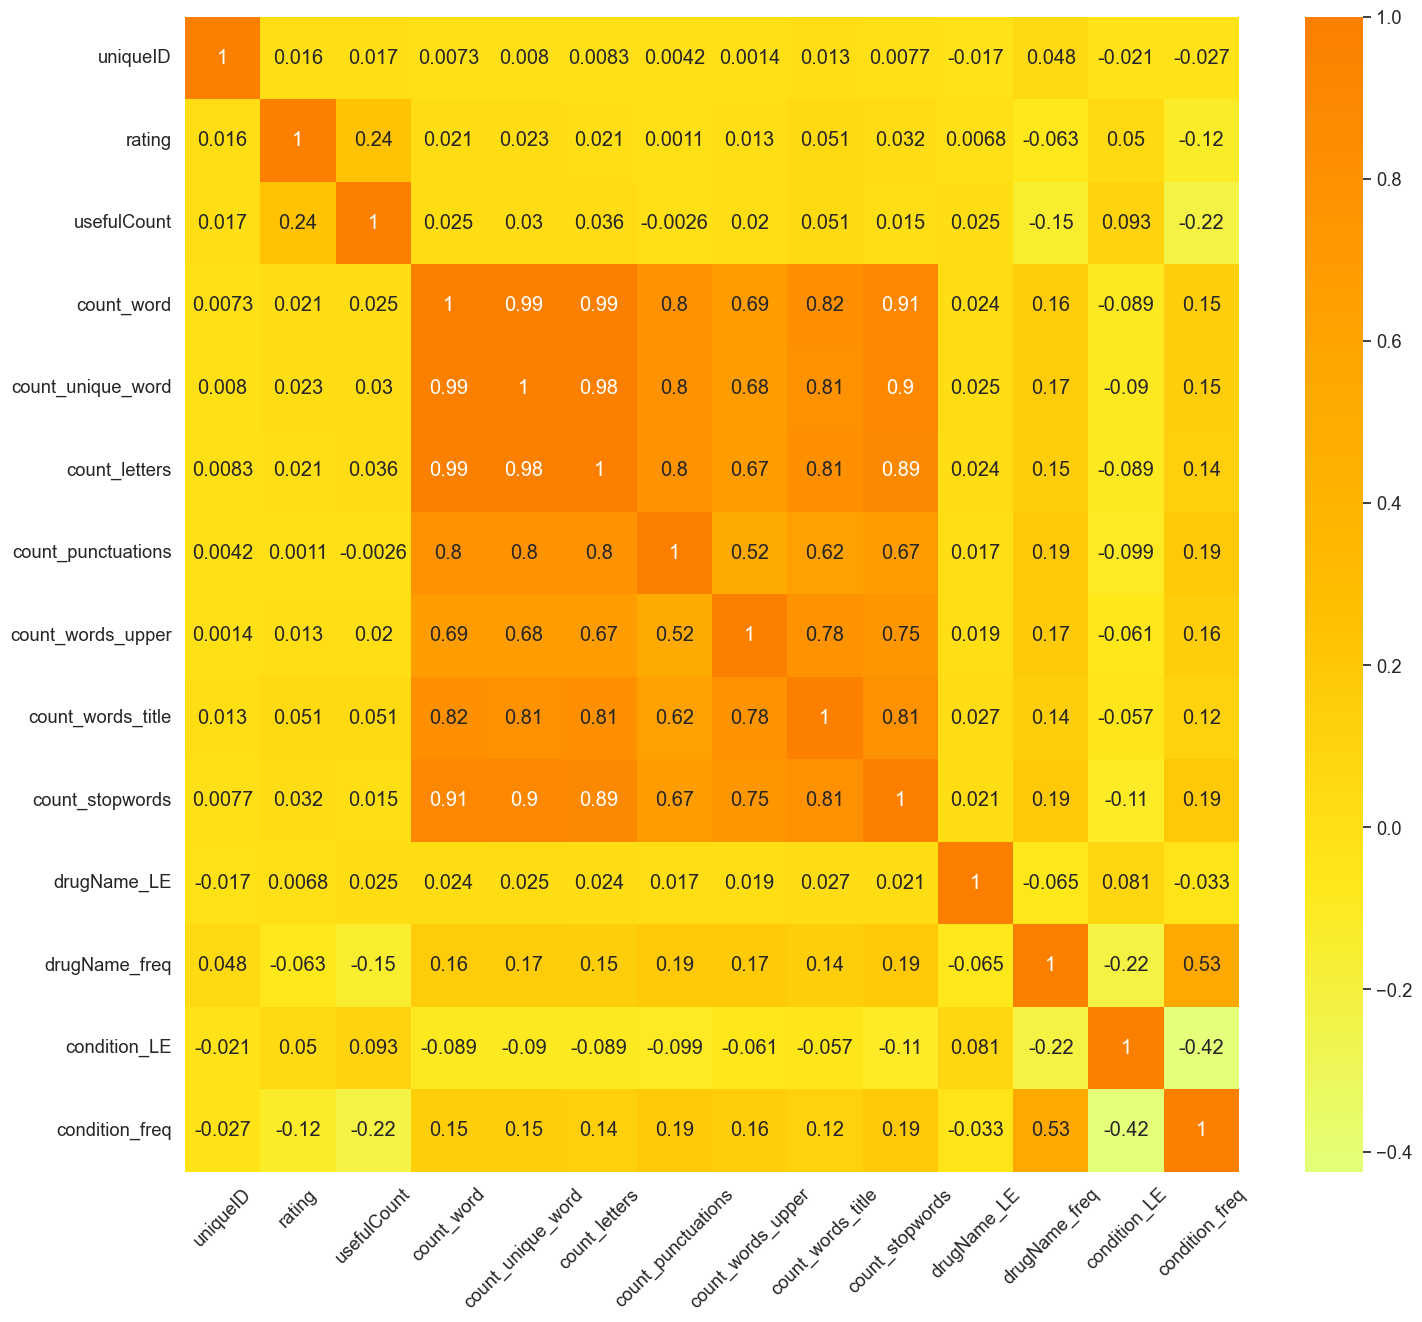

In [39]:
# Correlation Heatmap of the features engineered
plt.rcParams['figure.figsize'] = [17,15]
sns.set(font_scale = 1.2)
corr = data.select_dtypes(include = 'int64').corr()
sns_ = sns.heatmap(corr, annot = True, cmap = 'Wistia')
plt.setp(sns_.get_xticklabels(), rotation = 45);

In [40]:
import warnings
warnings.filterwarnings('ignore')

# LightGBM and XGBoost
from xgboost import XGBClassifier
from lightgbm import LGBMModel, LGBMClassifier, plot_importance

# data splitting, metrics and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from sklearn.ensemble import GradientBoostingClassifier

import sklearn, xgboost, lightgbm
print("Versions: sklearn-", sklearn.__version__, "xgboost-", xgboost.__version__, "lightgbm-", lightgbm.__version__)

Versions: sklearn- 1.6.1 xgboost- 3.0.5 lightgbm- 4.6.0


In [41]:
# Selecting features for model training
feature_cols = [
    'usefulCount', 'sentiment', 'day', 'month', 'Year',
    'sentiment_clean', 'count_word', 'count_unique_word', 'count_letters',
    'count_punctuations', 'count_words_upper', 'count_words_title',
    'count_stopwords', 'mean_word_len',
    'drugName_LE', 'drugName_freq', 'drugName_mean_sentiment',
    'condition_LE', 'condition_freq', 'condition_mean_sentiment'
]
X = data[feature_cols]
y = data['Review_Sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (149708, 20)
Testing set size: (64161, 20)


In [42]:
# Initialize LightGBM Classifier with hyperparameters and random_state for reproducibility
clf = LGBMClassifier(
    n_estimators=10000,
    learning_rate=0.10,
    num_leaves=30,
    subsample=0.9,
    max_depth=7,
    reg_alpha=0.1,      # L1 regularization
    reg_lambda=0.1,     # L2 regularization
    min_split_gain=0.01,
    min_child_weight=2,
    verbose=-1,
    random_state=42
)

# Train the model
model = clf.fit(X_train, y_train)

# Test set predictions
predictions = model.predict(X_test)

In [43]:
# Metrics
print("Accuracy of LightGBM model: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

Accuracy of LightGBM model: 0.8906

Confusion Matrix:
 [[11124  4853]
 [ 2167 46017]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.70      0.76     15977
         1.0       0.90      0.96      0.93     48184

    accuracy                           0.89     64161
   macro avg       0.87      0.83      0.84     64161
weighted avg       0.89      0.89      0.89     64161



<Figure size 1200x900 with 0 Axes>

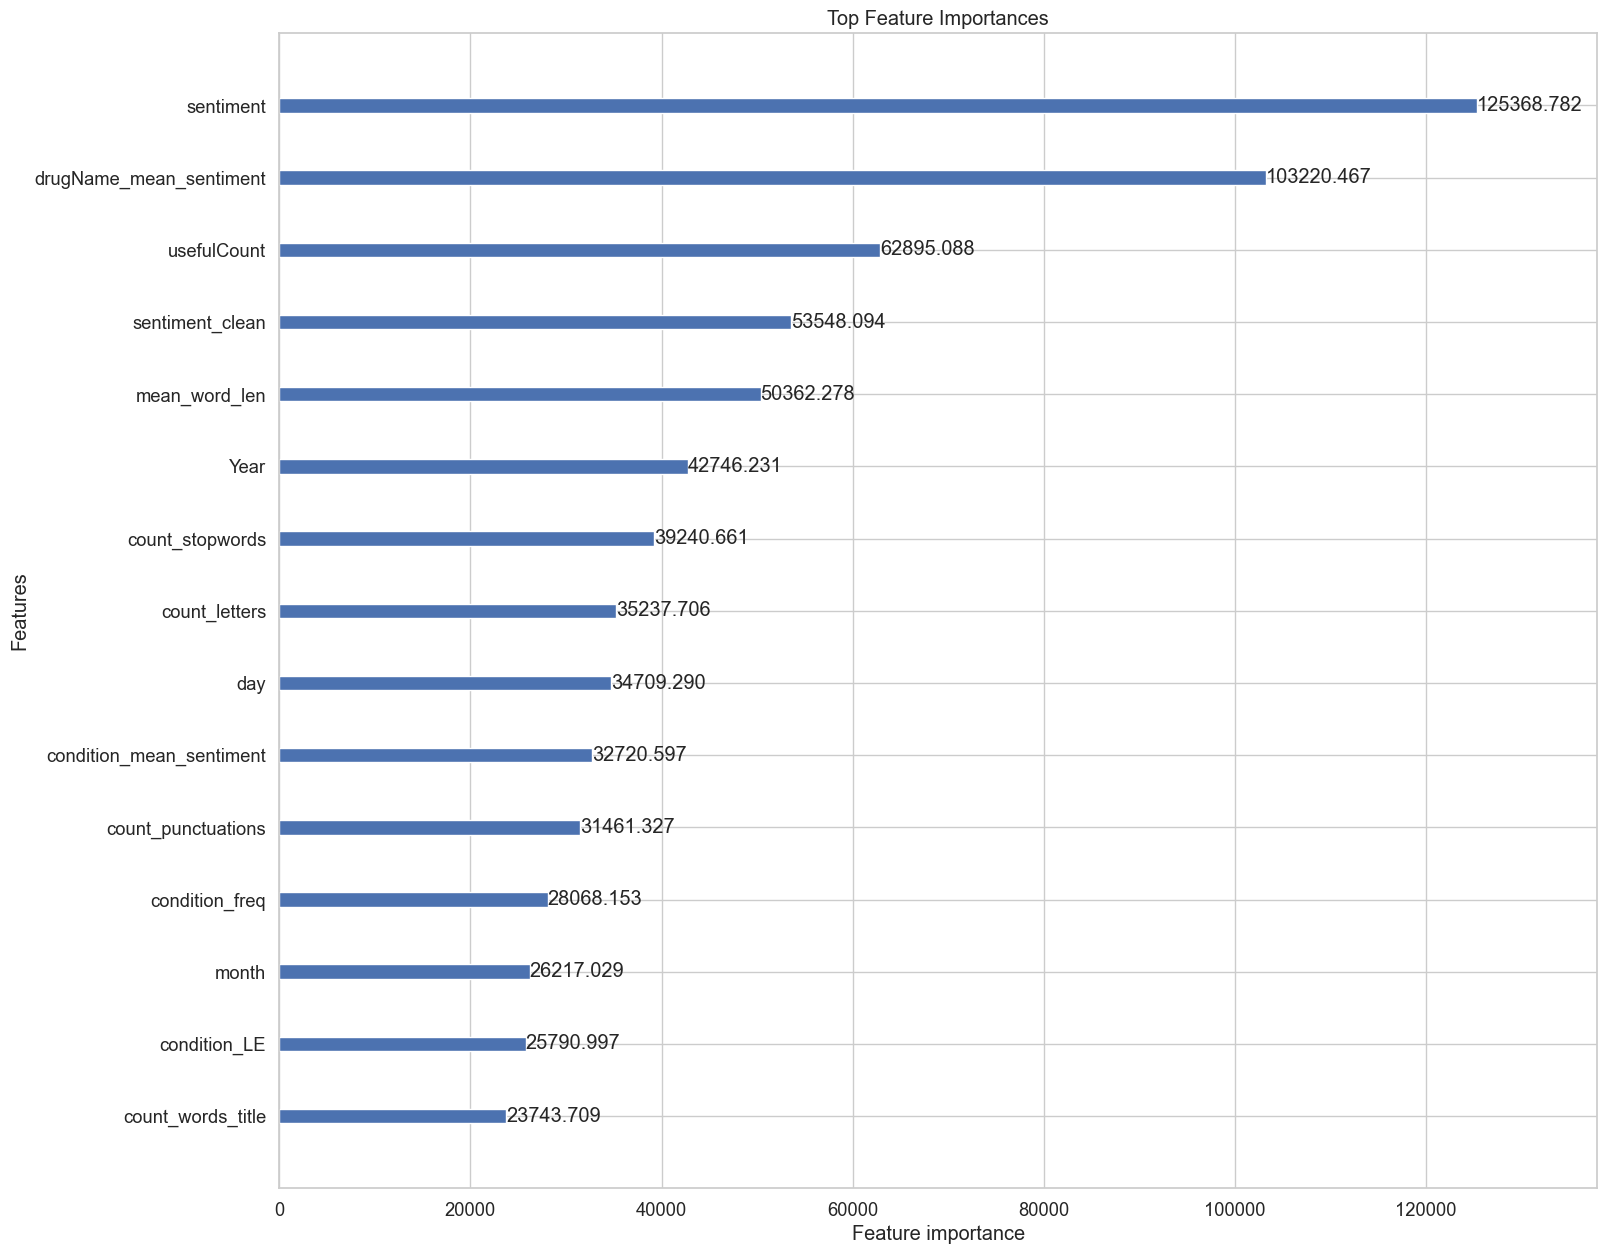

In [44]:
# Feature Importance
plt.figure(figsize=(12, 9))
sns.set(style='whitegrid', font_scale=1.2)
plot_importance(model, max_num_features=15, importance_type='gain', title='Top Feature Importances')
plt.show()

In [45]:
import joblib

joblib.dump(model, "lgbm_model.pkl")
joblib.dump(label_encoder_feat['drugName'], "label_encoder_drug.pkl")
joblib.dump(label_encoder_feat['condition'], "label_encoder_condition.pkl")


['label_encoder_condition.pkl']